<a href="https://colab.research.google.com/github/ddekun/ml_in_business/blob/lesson4/lesson4/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Машинное обучение в бизнесе

## Урок 4. Uplift-моделирование

### Домашнее задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [5]:
!pip install mplcyberpunk
!pip install scikit-uplift

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 KB 1.6 MB/s eta 0:00:00


In [6]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier


# Visual libraries
import matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns
import mplcyberpunk

%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})
# sns.set(font_scale=1.5)
plt.style.use('cyberpunk')

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels

In [7]:
import warnings
warnings.filterwarnings('ignore')

**1. Скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention**

In [8]:
df = pd.read_csv('/content/drive/MyDrive/Geekbrains/ml_in_business/lesson4/data.csv')

df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


**2. Там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.**

In [10]:
df['offer'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64

In [11]:
df.rename(columns= {'conversion' : 'target',  'offer' : 'treatment'}, inplace=True)
df['treatment'] = df['treatment'].map({'No Offer': 0, 'Buy One Get One': 1, 'Discount': 1})
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


In [12]:
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

**3. Сделать разбиение набора данных не тренировочную и тестовую**

In [14]:
#разделим данные на train/test
indices_learn, indices_valid = train_test_split(df.index, test_size=0.2, random_state=42)

**4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)**

In [15]:
df['recency'].value_counts()

1     8952
10    7565
2     7537
9     6441
3     5904
4     5077
6     4605
5     4510
7     4078
11    3504
8     3495
12    2332
Name: recency, dtype: int64

In [16]:
df['history'].value_counts()

29.99      7947
53.79         9
81.20         9
33.18         8
44.14         8
           ... 
433.13        1
196.43        1
1108.21       1
1025.31       1
552.94        1
Name: history, Length: 34833, dtype: int64

In [17]:
df['used_discount'].value_counts()

1    35266
0    28734
Name: used_discount, dtype: int64

In [18]:
df['used_bogo'].value_counts()

1    35182
0    28818
Name: used_bogo, dtype: int64

In [19]:
df['zip_code'].value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

In [20]:
df['is_referral'].value_counts()

1    32144
0    31856
Name: is_referral, dtype: int64

In [22]:
df['channel'].value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

In [24]:
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [25]:
df['target'].value_counts()

0    54606
1     9394
Name: target, dtype: int64

In [26]:
cat_columns = ['zip_code', 'channel']
feature_num_names = ['recency', 'history']

In [27]:
one_hot = pd.get_dummies(df[cat_columns])
df = df.drop(cat_columns, axis=1)
df = df.join(one_hot)

In [28]:
df['treatment'] = df['treatment'].astype('int64').fillna(0)

In [29]:
scaler = StandardScaler()

df_norm = df.copy()
df[feature_num_names] = scaler.fit_transform(df_norm[feature_num_names])

In [30]:
df.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,1.207751,-0.389003,1,0,0,1,0,0,1,0,0,1,0
1,0.067359,0.339614,1,1,1,0,0,1,0,0,0,0,1
2,0.352457,-0.239836,0,1,1,1,0,0,1,0,0,0,1
3,0.922653,1.693278,1,0,1,1,0,1,0,0,0,0,1
4,-1.073034,-0.768068,1,0,0,1,0,0,0,1,0,0,1


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recency               64000 non-null  float64
 1   history               64000 non-null  float64
 2   used_discount         64000 non-null  int64  
 3   used_bogo             64000 non-null  int64  
 4   is_referral           64000 non-null  int64  
 5   treatment             64000 non-null  int64  
 6   target                64000 non-null  int64  
 7   zip_code_Rural        64000 non-null  uint8  
 8   zip_code_Surburban    64000 non-null  uint8  
 9   zip_code_Urban        64000 non-null  uint8  
 10  channel_Multichannel  64000 non-null  uint8  
 11  channel_Phone         64000 non-null  uint8  
 12  channel_Web           64000 non-null  uint8  
dtypes: float64(2), int64(5), uint8(6)
memory usage: 3.8 MB


**5. Провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями**

In [32]:
X_train = df.loc[indices_learn, :].drop(["treatment", "target"] , axis=1)
y_train = df.loc[indices_learn, 'target']
treat_train = df.loc[indices_learn, 'treatment']

X_val = df.loc[indices_valid, :].drop(["treatment", "target"] , axis=1)
y_val = df.loc[indices_valid, 'target']
treat_val = df.loc[indices_valid, 'treatment']

models_results = {
    'approach': [],
    'uplift@30%': [],
    'uplift@20%': [],
    'uplift@10%': []
}

In [33]:
X_train.head()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
43820,-0.502837,-0.051124,0,1,0,0,1,0,0,0,1
36500,1.492850,-0.435186,0,1,1,0,1,0,0,0,1
38039,0.922653,-0.827992,0,1,0,1,0,0,0,0,1
1954,-1.073034,-0.224455,0,1,1,0,0,1,0,0,1
28361,0.922653,-0.568502,1,0,0,0,1,0,0,1,0


**Способ №1: модель с признаком коммуникации**

uplift@10%: 0.0695
uplift@20%: 0.1048
uplift@30%: 0.0919


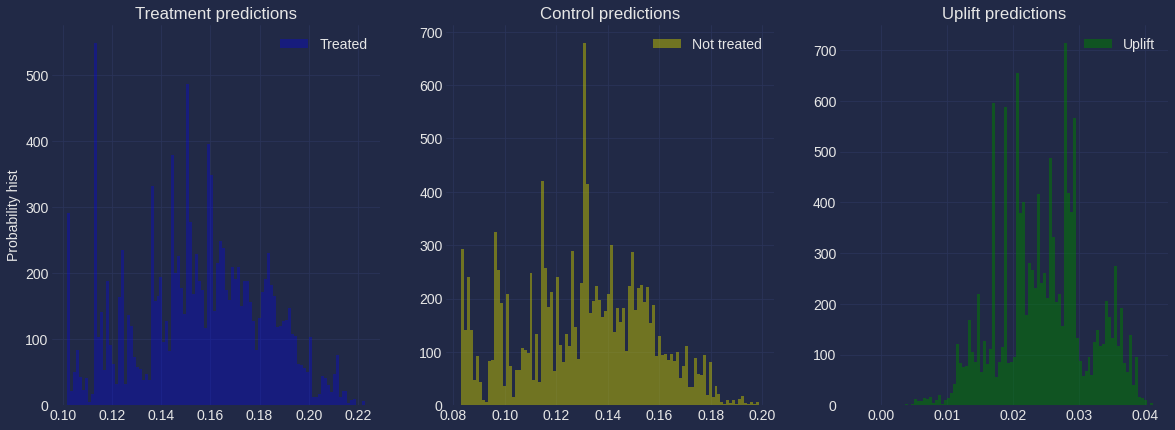

In [34]:
sm = SoloModel(RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42, n_jobs=-1))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
sm_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)
models_results['uplift@30%'].append(sm_score_30)

print(f'uplift@10%: {sm_score_10:.4f}')
print(f'uplift@20%: {sm_score_20:.4f}')
print(f'uplift@30%: {sm_score_30:.4f}')

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_
# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [35]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_in_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,0.222197
1,recency,0.217750
2,history,0.215516
3,treatment,0.181351
4,used_bogo,0.051286
5,channel_Phone,0.035183
6,zip_code_Rural,0.034291
7,channel_Web,0.022834
8,used_discount,0.012467
9,channel_Multichannel,0.003460


**Способ №2: модель с трансформацией таргета**

In [36]:
ct = ClassTransformation(RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42, n_jobs=-1))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_val)

ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)
ct_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score_10)
models_results['uplift@30%'].append(ct_score_20)
models_results['uplift@30%'].append(ct_score_30)

print(f'uplift@10%: {ct_score_10:.4f}')
print(f'uplift@20%: {ct_score_20:.4f}')
print(f'uplift@30%: {ct_score_30:.4f}')

uplift@10%: 0.1369
uplift@20%: 0.1157
uplift@30%: 0.1023


**Способ №3: две независимые моделями**

uplift@10%: 0.1247
uplift@20%: 0.0959
uplift@30%: 0.0940


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f834f6e1f40>,
      dtype=object)

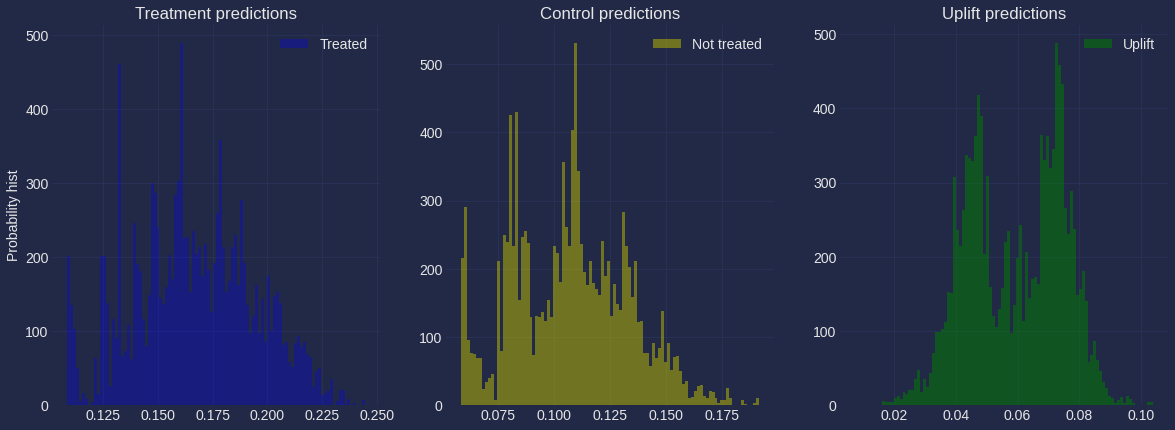

In [37]:
tm = TwoModels(
    estimator_trmnt=RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42, n_jobs=-1),
    estimator_ctrl=RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42, n_jobs=-1),
    method='vanilla'
)

tm = tm.fit(X_train, y_train, treat_train)

uplift_tm = tm.predict(X_val)

tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)
tm_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)
models_results['uplift@30%'].append(tm_score_30)

print(f'uplift@10%: {tm_score_10:.4f}')
print(f'uplift@20%: {tm_score_20:.4f}')
print(f'uplift@30%: {tm_score_30:.4f}')

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_)

**6. В конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей**

In [39]:
united_table = pd.DataFrame({
    'approach':['SoloModel', 'ClassTransformation', 'TwoModels'],
    'uplift@10%': [sm_score_10, ct_score_10, tm_score_10],
    'uplift@20%': [sm_score_20, ct_score_20, tm_score_20],
})

united_table

,approach,uplift@10%,uplift@20%
0,SoloModel,0.069486,0.104799
1,ClassTransformation,0.136896,0.115658
2,TwoModels,0.124692,0.095939


**7. Построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево**

In [41]:
features = [col for col in X_train]

In [45]:
!git clone https://github.com/uber/causalml
%cd causalml
!pip install -r requirements.txt
!python setup.py build_ext --inplace
!python setup.py install

Cloning into 'causalml'...
remote: Enumerating objects: 3431, done.
remote: Counting objects: 100% (303/303), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 3431 (delta 179), reused 238 (delta 147), pack-reused 3128
Receiving objects: 100% (3431/3431), 61.83 MiB | 24.69 MiB/s, done.
Resolving deltas: 100% (2123/2123), done.
/content/causalml
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 11.5 MB/s eta 0:00:00
Compiling causalml/inference/tree/causal/_criterion

CPU times: user 905 ms, sys: 92 ms, total: 997 ms
Wall time: 1.13 s


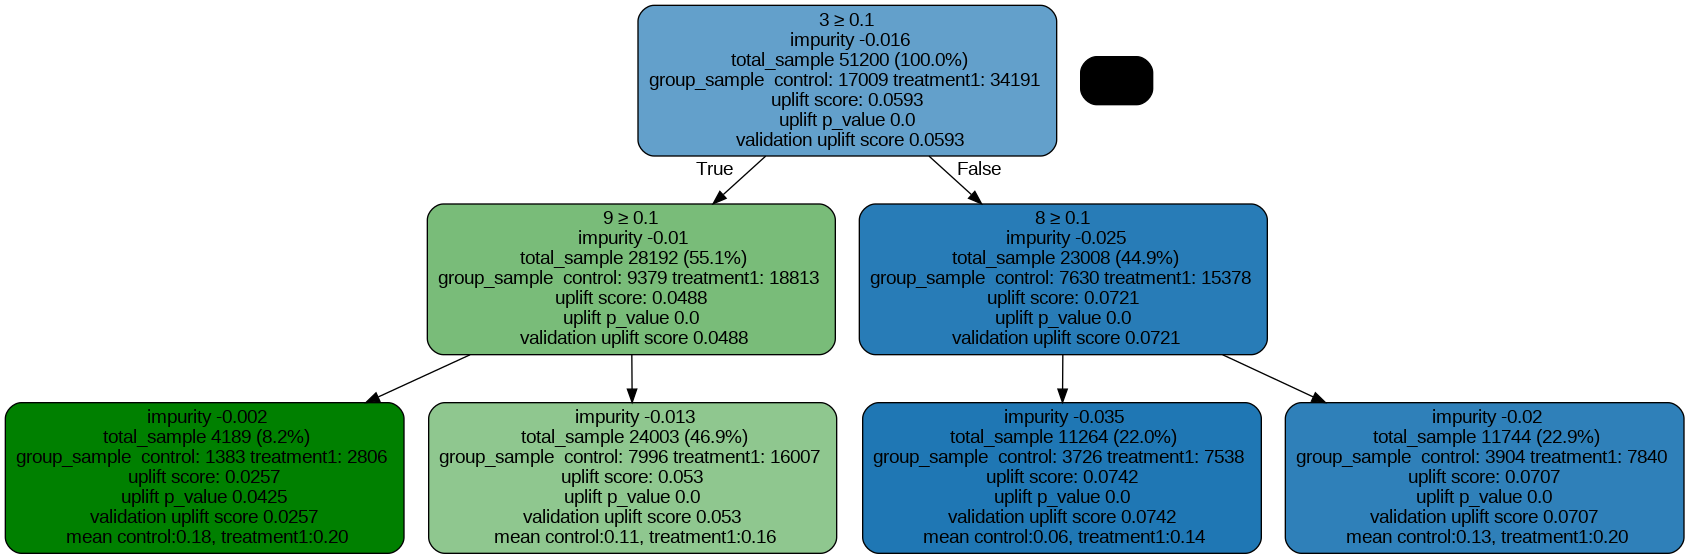

In [52]:
%%time

from IPython.display import Image

from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=3, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())